#### Install & Import

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
np.set_printoptions(3)
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_theme(style="whitegrid")

np.random.seed(42)
torch.manual_seed(42)

In [ ]:
!pip install -q gdown --upgrade

In [ ]:
!pip install -q git+https://github.com/maciejkula/spotlight.git@master#egg=spotlight

#### Load Dataset

In [ ]:
'''Clean dataset'''
!gdown 'https://drive.google.com/uc?id=1l_UUpfgK9c74csvkiLIXDtKiuHig7xHA'  # clean_data.csv

Downloading...
From: https://drive.google.com/uc?id=1l_UUpfgK9c74csvkiLIXDtKiuHig7xHA
To: /content/clean_data.csv
100% 238M/238M [00:00<00:00, 330MB/s]


In [ ]:
df = pd.read_csv('clean_data.csv')
df.rename(columns={'score': 'rating'}, inplace=True)

In [ ]:
df.head()

,username,user,type,item,title,rating
0,JBBeast,6779,anime,2453,Dragon Ball: Episode of Bardock,1
1,nightfury10,14591,anime,10312,Tsuujou Kougeki ga Zentai Kougeki de Ni-kai Ko...,1
2,AzzurroKurai97X,3707,anime,11275,ēlDLIVE,1
3,VhlleX,10591,anime,2633,Eromanga-sensei,1
4,Timelime,10371,anime,9553,Sword Art Online II,1


#### Utility Functions

##### EDA

In [ ]:
def sparse_to_df(sm):
    u, i = sm.nonzero()
    r = sm.data
    return pd.DataFrame({'user': u, 'item': i, 'rating': r})

def domain_sparsity(matrix):
    '''Sparsity: 1 minus the density of the matrix'''
    if isinstance(matrix, sparse.csr_matrix):
        matrix = sparse_to_df(matrix)

    entries_in_matrix = len(matrix) / (matrix.user.nunique() * matrix.item.nunique())
    sparsity_in_percent = (1 - entries_in_matrix) * 100
    return f'{round(sparsity_in_percent, 2)}%'

def quick_stats(df):
    '''Quick numbers'''
    print(f'Number of users: {df.username.nunique()}')
    print(f'Number of items: {df.title.nunique()}')
    print(f'Number of transactions: {df.shape[0]}')
    print('----------')

    '''Ratings distributions'''
    mean_ratings = df.groupby('username')['rating'].agg('mean')
    sns.displot(mean_ratings, height=6, aspect=2, kde=True).set(title='Distribution of User Ratings')

    '''Number and proportion of each item type'''
    manga = df[df['type'] == 'manga'].copy()
    anime = df[df['type'] == 'anime'].copy()
    
    print(f'Anime transactions: {len(anime)}')
    print(f'Anime proportion in data: {round(len(anime) / len(df), 2)}')
    print(f'Anime sparsity: {domain_sparsity(anime)}')
    print('----------')

    print(f'Manga transactions: {len(manga)}')
    print(f'Manga proportion in data: {round(len(manga) / len(df), 2)}')
    print(f'Manga sparsity: {domain_sparsity(manga)}')
    print('----------')

In [ ]:
def domain_overlap(df):
    # pisahkan domain
    anime_df = df[df['type'] == 'anime'].copy()
    manga_df = df[df['type'] == 'manga'].copy()

    anime_users = set(anime_df.username.unique())
    manga_users = set(manga_df.username.unique())

    # cek overlap
    anime_and_manga_users = anime_users.intersection(manga_users)
    anime_only_users = anime_users.difference(manga_users)
    manga_only_users = manga_users.difference(anime_users)

    print(f"Both anime and manga users: {len(anime_and_manga_users)}")
    print(f"Anime only users: {len(anime_only_users)}")
    print(f"Manga only users: {len(manga_only_users)}")

##### Train-test Split

In [ ]:
'''Utilities for train test split with sparse matrices'''
# https://gist.github.com/tgsmith61591/ce7d614d7a0442f94cd5ae5d1e51d3c2
import numpy as np
from scipy import sparse
from sklearn.utils.validation import check_random_state
from sklearn.utils import validation as skval

DTYPE = np.float64  # implicit asks for doubles, not float32s...


def check_consistent_length(u, i, r):
    """Ensure users, items, and ratings are all of the same dimension."""
    skval.check_consistent_length(u, i, r)
    return np.asarray(u), np.asarray(i), np.asarray(r, dtype=DTYPE)


def _make_sparse_csr(data, rows, cols, dtype=DTYPE):
    # check lengths
    check_consistent_length(data, rows, cols)
    data, rows, cols = (np.asarray(x) for x in (data, rows, cols))

    shape = (np.unique(rows).shape[0], np.unique(cols).shape[0])
    return sparse.csr_matrix((data, (rows, cols)),
                             shape=shape, dtype=dtype)


def to_sparse_csr(u, i, r, axis=0, dtype=DTYPE):
    """Create a sparse ratings matrix."""
    if axis not in (0, 1):
        raise ValueError("axis must be an int in (0, 1)")

    rows = u if axis == 0 else i
    cols = i if axis == 0 else u
    return _make_sparse_csr(data=r, rows=rows, cols=cols, dtype=dtype)


def _validate_train_size(train_size):
    """Train size should be a float between 0 and 1."""
    assert isinstance(train_size, float) and (0. < train_size < 1.), \
        "train_size should be a float between 0 and 1"


def _get_stratified_tr_mask(u, i, train_size, random_state):
    _validate_train_size(train_size)  # validate it's a float
    random_state = check_random_state(random_state)
    n_events = u.shape[0]

    # this is our train mask that we'll update over the course of this method
    train_mask = random_state.rand(n_events) <= train_size  # type: np.ndarray

    # we have a random mask now. For each of users and items, determine which
    # are missing from the mask and randomly select one of each of their
    # ratings to force them into the mask
    for array in (u, i):
        # e.g.:
        # >>> array = np.array([1, 2, 3, 3, 1, 3, 2])
        # >>> train_mask = np.array([0, 1, 1, 1, 0, 0, 1]).astype(bool)
        # >>> unique, counts = np.unique(array, return_counts=True)
        # >>> unique, counts
        # (array([1, 2, 3]), array([2, 2, 3]))

        # then present:
        # >>> present
        # array([2, 3, 3, 2])
        present = array[train_mask]

        # and the test indices:
        # >>> test_vals
        # array([1, 1, 3])
        test_vals = array[~train_mask]

        # get the test indices that are NOT present (either
        # missing items or users)
        # >>> missing
        # array([1])
        missing = np.unique(test_vals[np.where(
            ~np.in1d(test_vals, present))[0]])

        # If there is nothing missing, we got perfectly lucky with our random
        # split and we'll just go with it...
        if missing.shape[0] == 0:
            continue

        # Otherwise, if we get to this point, we have to add in the missing
        # level to the mask to make sure at least one of each of those makes
        # it into the training data (so we don't lose a factor level for ALS)
        array_mask_missing = np.in1d(array, missing)

        # indices in "array" where we have a level that's currently missing
        # and that needs to be added into the mask
        where_missing = np.where(array_mask_missing)[0]  # e.g., array([0, 4])

        # I don't love having to loop here... but we'll iterate "where_missing"
        # to incrementally add in items or users until all are represented
        # in the training set to some degree
        added = set()
        for idx, val in zip(where_missing, array[where_missing]):
            # if we've already seen and added this one
            if val in added:  # O(1) lookup
                continue

            train_mask[idx] = True
            added.add(val)

    return train_mask


def _make_sparse_tr_te(users, items, ratings, train_mask):
    # now make the sparse matrices
    r_train = to_sparse_csr(u=users[train_mask], i=items[train_mask],
                            r=ratings[train_mask], axis=0)

    r_test = to_sparse_csr(u=users, i=items, r=ratings, axis=0)
    return r_train, r_test


def train_test_split(u, i, r, train_size=0.75, random_state=None):
    # make sure all of them are numpy arrays and of the same length
    users, items, ratings = check_consistent_length(u, i, r)

    train_mask = _get_stratified_tr_mask(
        users, items, train_size=train_size,
        random_state=random_state)

    return _make_sparse_tr_te(users, items, ratings, train_mask=train_mask)

##### Aggregation (Domain Train-test Split)

In [ ]:
def domain_train_test_split(S, T, train_size=0.75, random_state=None):
    '''Train Test splits scenario for cross-domain data'''
    # we want to hide training samples from T (mask applied on T)
    # if the mask is `True`, then it appear in training set
    S_users = S.user.values; S_items = S.item.values; S_ratings = S.rating.values
    T_users = T.user.values; T_items = T.item.values; T_ratings = T.rating.values

    T_train_mask = _get_stratified_tr_mask(
        T_users, T_items, train_size=train_size,
        random_state=random_state)
    
    S_pad = np.ones(len(S), dtype=bool)  # all source data appear in train set
    train_mask = np.concatenate((S_pad, T_train_mask))

    # aggregate source and target data
    users = np.concatenate((S_users, T_users))
    items = np.concatenate((S_items, T_items))
    ratings = np.concatenate((S_ratings, T_ratings))

    # handle row dimensions exceeds error
    # do this after concatenating with Source, so that there's no duplicate indexes
    T_users, _ = T.user.factorize()
    T_items, _ = T.item.factorize()

    # make split
    T_train, T_test = _make_sparse_tr_te(T_users, T_items, T_ratings, train_mask=T_train_mask)
    FS_train, FS_test = _make_sparse_tr_te(users, items, ratings, train_mask=train_mask)

    return T_train, T_test, FS_train, FS_test

##### RQ1

In [ ]:
def get_mean_score(sparse_matrix, axis):
  arr = sparse_matrix.toarray()
  arr[arr == 0] = np.nan
  return np.nanmean(arr, axis=axis)

In [ ]:
class BaselineItem:
  def __init__(self, train):
    self.train = train
  
  def get_predictions(self):
    return get_mean_score(self.train, 0)  # item mean


def baseline_rmse_score(model, test):
  items_mean = model.get_predictions()
  items_id = test.nonzero()[1]
  predictions = items_mean[items_id]
  return np.sqrt(((test.data - predictions) ** 2).mean())

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, f1_score, r2_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.interactions import Interactions

def to_interactions(*sparse_matrix):
    '''Turn train-test dataset to interaction class for compat with Spotlight's model'''
    for sm in sparse_matrix:
        user_ids = sm.nonzero()[0]
        item_ids = sm.nonzero()[1]
        ratings = sm.data

        yield Interactions(user_ids, item_ids, ratings)


def load_data(key):
    keys = { 'Anime Single': 'Anime', 'Manga Single': 'Manga', 'Manga Cross': 'Full_Anime', 'Anime Cross': 'Full_Manga' }
    assert key in keys, 'Key must be either `Anime Single, Manga Single, Manga Cross, or Anime Cross`'
    
    # add folders path as necessary
    D = sparse.load_npz(f'{keys.get(key)}_train.npz')
    D_test = sparse.load_npz(f'{keys.get(key)}_test.npz')

    return D, D_test


def rmse_score(model, test, batch=500_000):
    '''RMSE scoring that works with batch predictions'''
    N = len(test.user_ids)
    i = 0
    predictions = []
    
    for _ in range(0, N, batch):
        get_batch = slice(i*500_000, (i+1)*500_000)
        
        pred = model.predict(test.user_ids[get_batch], test.item_ids[get_batch])
        predictions.extend(pred)

        i += 1

    return round(np.sqrt(((test.ratings - np.array(predictions)) ** 2).mean()), 3)

In [ ]:
def save_model(config):
    '''
    For reproducibility, fit on TRAIN.
    For recommendations, fit on TEST.
    '''
    LATENT_DIM, DOMAIN = config
    _, TEST = load_data(DOMAIN)

    model = load_model(LATENT_DIM)
    model.fit(TEST, verbose=True)

    # `test` for recommendation
    PATH = f'{DOMAIN}_test__{LATENT_DIM}.pth'
    torch.save(model, PATH)

##### RQ2

In [ ]:
'''Evaluation Utility'''
def _get_batch_predictions(model, test, batch=500_000):
    predictions = []
    N = len(test.user_ids)
    i = 0

    for _ in range(0, N, batch):
        get_batch = slice(i*500_000, (i+1)*500_000)
        pred = model.predict(test.user_ids[get_batch], test.item_ids[get_batch])
        predictions.extend(pred)
        i += 1
    
    return np.array(predictions)


def _rmse_score(ratings, predictions):
    return round(np.sqrt(((ratings - predictions) ** 2).mean()), 3)


def roc_score(ratings, predictions, t=6):
    '''Return TP, TN, FP, FN'''
    TP = TN = FP = FN = 0

    for actual, pred in zip(ratings, predictions):
        if actual >= t and pred >= t:
            TP += 1
        elif actual >= t > pred:
            FN += 1
        elif pred >= t > actual:
            FP += 1
        elif actual < t and pred < t:
            TN += 1
        else:
            raise('Unknown condition just happened')
    
    return TP, TN, FP, FN


def _balanced_accuracy(TPR, FPR):
    return (TPR + (1-FPR))/2


def score(model, test, t=6):
    predictions = _get_batch_predictions(model, test)
    binary_rating = test.ratings >= t; binary_predictions = predictions >= t

    rmse = _rmse_score(test.ratings, predictions)
    print(f'RMSE: {rmse}')
    print('====================================')

    TP, TN, FP, FN = roc_score(test.ratings, predictions)
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    print(f'True Positive Rate: {round(TPR, 3)}')
    print(f'False Positive Rate: {round(FPR, 3)}')
    print('====================================')

    ba = _balanced_accuracy(TPR, FPR)
    print(f'Balanced Accuracy: {round(ba, 3)}')
    print('====================================')


'''Modeling Utility'''
def load_model(LATENT_DIM, LR=1e-3, L2=1e-6, NUM_EPOCHS=20):
    model = ExplicitFactorizationModel(loss='regression',
                                       embedding_dim=LATENT_DIM,
                                       n_iter=NUM_EPOCHS,
                                       learning_rate=LR,
                                       batch_size=BATCH_SIZE,
                                       l2=L2,
                                       random_state=np.random.RandomState(RANDOM_SEED),
                                       use_cuda=True)
    return model

##### Visual Results

In [ ]:
def plot_results(title, results):
    plt.scatter(results['emb_size'], results['rmse'])
    plt.plot(results['emb_size'], results['rmse'])
    plt.xticks(results['emb_size'])
    plt.ylabel('RMSE')
    plt.xlabel('Embedding Size')
    plt.title(f'{title}')

##### Rekomendasi

In [ ]:
from functools import partial

def _post_rank(user_id, offset, recs, df):
    '''Final recommendation list for the user, based on `unseen items recommendation`'''
    f = df.user == (user_id + offset)           # filter current user from df
    seen_items = df.loc[f]['item'].values       # get current user seen items
    recs = set(recs.index)
    return list(recs.difference(seen_items))    # take only unseen items


def _topk_rank(user_id, k, item_type, crm, items_index, df):
    '''Recommend top K items of certain type based on the computed rating matrix
    
    Parameters
    ----------
    user_id     : int. the user's ID
    k           : int. number of items to recommend
    item_type   : str. either anime or manga
    crm         : ndarray. the computex matrix
    items_index : dataframe. a dataframe with `item` index and `title` column
    df          : dataframe. the whole user-item dataframe
    '''
    assert user_id > 0
    assert k > 0
    assert item_type in ('anime', 'manga')

    # get ratings
    ratings = crm[user_id]

    # generate ranking
    ranking = np.argpartition(ratings, -k)[-k:]
    sorted_ranking = ranking[np.argsort(ratings[ranking])][::-1]  # -1 for descending

    # generate recommendations. sorted and filtered by `type`
    recs = items_index.iloc[sorted_ranking].copy()
    recs = recs.loc[recs['type'] == item_type]

    '''
    This hardcoded offset is the number of skipped users from previously batch computed rating matrix
    '''
    OFFSET = 14900  

    # post_rank: only recommend unseen items
    unseen_items = _post_rank(user_id, OFFSET, recs, df)
    return items_index.iloc[unseen_items]

#### Eksplorasi Data

Number of users: 15744
Number of items: 21437
Number of transactions: 4397293
----------
Anime transactions: 3841664
Anime proportion in data: 0.87
Anime sparsity: 97.83%
----------
Manga transactions: 555629
Manga proportion in data: 0.13
Manga sparsity: 99.6%
----------


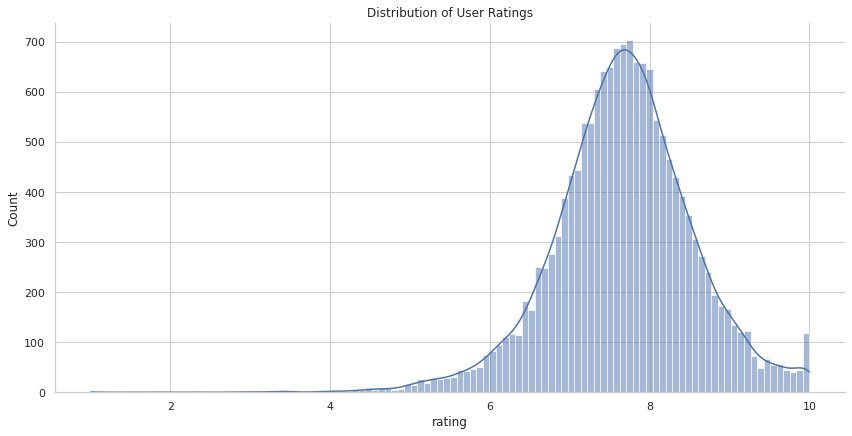

In [ ]:
quick_stats(df)

##### Identifikasi Overlap

In [ ]:
domain_overlap(df)

Both anime and manga users: 12152
Anime only users: 3574
Manga only users: 18


#### Modeling

##### Dataset

In [ ]:
anime_df = df[df['type'] == 'anime'].copy()
manga_df = df[df['type'] == 'manga'].copy()

In [ ]:
'''Create the dataset
domain_train_test_split
    params: source, target, train_size, random_state
    return: target train, target test, source + target train, source + target test
'''
Manga_train, Manga_test, Full_Anime_train, Full_Anime_test = domain_train_test_split(anime_df, 
                                                                                     manga_df,
                                                                                     train_size=.8,
                                                                                     random_state=42)
Anime_train, Anime_test, Full_Manga_train, Full_Manga_test = domain_train_test_split(manga_df,
                                                                                     anime_df,
                                                                                     train_size=.8,
                                                                                     random_state=42)

In [ ]:
'''Already created dataset'''
# Anime
# !gdown --quiet 1GtMOfI2CPZNk836Y3_W8jVro9fx-JlaL
# !gdown --quiet 1R5iZDNtu4XQe2RtMhX4zsYsjorA2bVCE

# Manga
!gdown --quiet 1t1KTD3qqCuB_RtODorLr8Ny-3CHRGmKt
!gdown --quiet 1g-Uu5j0PzO4OK5ZYo7cnzf8Z72jPYcGw

# Full on Anime (Manga Cross-domain)
!gdown --quiet 1jVVsYy1-Sp4lzi4keBPW11oiH7pRA1ER
!gdown --quiet 15wEsqA5iCIhxk5ajHEHcJCehqNRd8MIx

# Full on Manga (Anime Cross-domain)
# !gdown --quiet 1Vimow1ALAt6CZoDIFu2FkTVmu5QfNgKY
# !gdown --quiet 1fEzyheR8KB7q63KpspH6oO3W73L53Jy1

##### RQ1

In [ ]:
'''Baseline for Anime'''
model = BaselineItem(Anime_train)
baseline_rmse_score(model, Anime_test)

1.571825332541627

In [ ]:
'''Baseline for Manga'''
model = BaselineItem(Manga_train)
baseline_rmse_score(model, Manga_test)

1.5729243122924206

In [ ]:
'''Unchanging hyperparameters'''
RANDOM_SEED = 42
BATCH_SIZE = 256
NUM_EPOCHS = 20

def run_rq1_experiments(experiments):
    '''Function to run the experiments'''
    for params in experiments:
        CASE, DOMAIN, LATENT_DIM, LEARNING_RATE, L2 = params
        
        print(f'Running experiments {CASE}')
        print(f'Setup:')
        print(f'DIM: {LATENT_DIM}')
        print(f'LR : {LEARNING_RATE}')
        print(f'L2 : {L2}')
        
        TRAIN_DATA, TEST_DATA = load_data(DOMAIN)
        train, test = to_interactions(TRAIN_DATA, TEST_DATA)
        
        model = ExplicitFactorizationModel(loss='regression',
                                        embedding_dim=LATENT_DIM,
                                        n_iter=NUM_EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        batch_size=BATCH_SIZE,
                                        l2=L2,
                                        random_state=np.random.RandomState(RANDOM_SEED),
                                        use_cuda=True)

        model.fit(train, verbose=True)
        rmse = rmse_score(model, test)
        print(f'RMSE: {rmse}')
        print('====================================\n')
        params.append(rmse)
        torch.cuda.empty_cache()

In [ ]:
rq1_experiments = [
    # Manga Cross-domain
    ['Manga CDRS: Varying Emb. Size', 'Manga Cross',   32, 1e-3, 1e-6],
    ['Manga CDRS: Varying Emb. Size', 'Manga Cross',   64, 1e-3, 1e-6],
    ['Manga CDRS: Varying Emb. Size', 'Manga Cross',  128, 1e-3, 1e-6],
    ['Manga CDRS: Varying Emb. Size', 'Manga Cross',  256, 1e-3, 1e-6],
    ['Manga CDRS: Varying Emb. Size', 'Manga Cross',  384, 1e-3, 1e-6],
    ['Manga CDRS: Varying Emb. Size', 'Manga Cross',  512, 1e-3, 1e-6],
    
    # Anime Cross-domain
    ['Anime CDRS: Varying LR', 'Anime Cross',  256, 1e-2, 1e-6],
    ['Anime CDRS: Varying LR', 'Anime Cross',  256, 5e-3, 1e-6],
    ['Anime CDRS: Varying L2', 'Anime Cross',  256, 1e-3, 1e-4],
    ['Anime CDRS: Varying L2', 'Anime Cross',  256, 1e-3, 1e-5],
    ['Anime CDRS: Varying L2', 'Anime Cross',  256, 1e-3, 1e-7],
    
    # Best Setup
    ['Best: Manga Single-Domain', 'Manga Single',   128, 1e-3, 1e-7],
    ['Best: Manga Cross-Domain',  'Manga Cross',    256, 1e-3, 1e-7],
    ['Best: Anime Single-Domain', 'Anime Single',   256, 1e-3, 1e-7],
    ['Best: Anime Cross-Domain',  'Anime Cross',    256, 1e-3, 1e-7],
]

In [ ]:
rq1_experiments = [
    ['Best: Manga Single-Domain', 'Manga Single',   128, 1e-3, 1e-7],
]

run_rq1_experiments(rq1_experiments)

Running experiments Best: Manga Single-Domain
Setup:
DIM: 128
LR : 0.001
L2 : 1e-07
Epoch 0: loss 27.431185939222274
Epoch 1: loss 3.744848541784365
Epoch 2: loss 2.1217055293684433
Epoch 3: loss 1.7655524950609174
Epoch 4: loss 1.5922828491035257
Epoch 5: loss 1.4608189079306273
Epoch 6: loss 1.3341192534837376
Epoch 7: loss 1.2038688096225576
Epoch 8: loss 1.0691465385958896
Epoch 9: loss 0.9249004047707932
Epoch 10: loss 0.7778145961941635
Epoch 11: loss 0.6331368805092626
Epoch 12: loss 0.4995058764976636
Epoch 13: loss 0.3847102288998645
Epoch 14: loss 0.29134057871417396
Epoch 15: loss 0.2192958951274321
Epoch 16: loss 0.16756815235589162
Epoch 17: loss 0.13077730562287093
Epoch 18: loss 0.10594557068804487
Epoch 19: loss 0.08974002892537042
RMSE: 0.653



##### RQ2

In [ ]:
target_sparsity = domain_sparsity(manga_df)
print(f'Initial Target Sparsity: {target_sparsity}')

Initial Target Sparsity: 99.6%


In [ ]:
def run_rq2_experiments(experiments):
    '''Run experiments from scratch'''
    assert len(experiments) != 0

    for params in experiments:
        CASE, DOMAIN, LATENT_DIM, LR, L2 = params
        print(f'Running experiments {CASE}\nSetup: {LATENT_DIM} emb. size. LR: {LR}. L2: {L2}')
        
        TRAIN_DATA, TEST_DATA = load_data(DOMAIN)
        train, test = to_interactions(TRAIN_DATA, TEST_DATA)
        model = load_model(LATENT_DIM, LR, L2)
        model.fit(train, verbose=True)
        score(model, test)

        torch.cuda.empty_cache()


def sensitivity_analysis(density_ratios, experiments):
    for train_data_size in density_ratios:
        M, M_test, FA, FA_test = domain_train_test_split(anime_df, manga_df, train_size=train_data_size, random_state=42)

        target_sparsity = domain_sparsity(M)
        print(f'\nTarget Sparsity with {train_data_size} Train Size: {target_sparsity}')

        run_rq2_experiments(experiments)

In [ ]:
density_ratios = [.5, .3, .2, .1, .05, .025, 0.005]
rq2_experiments = [
               [f'Manga Single-Domain.', 'Manga Single',  128, 1e-3, 1e-7],
               [f'Manga Cross-Domain.',  'Manga Cross',   256, 1e-3, 1e-7]
        ]
sensitivity_analysis(density_ratios, rq2_experiments)

In [ ]:
rq2_experiments = [
               [f'Manga Cross-Domain.',  'Manga Cross',   256, 1e-3, 1e-7]
        ]
sensitivity_analysis([0.005], rq2_experiments)

#### Visual Results

Text(0.5, 1.0, 'Experiment Results')

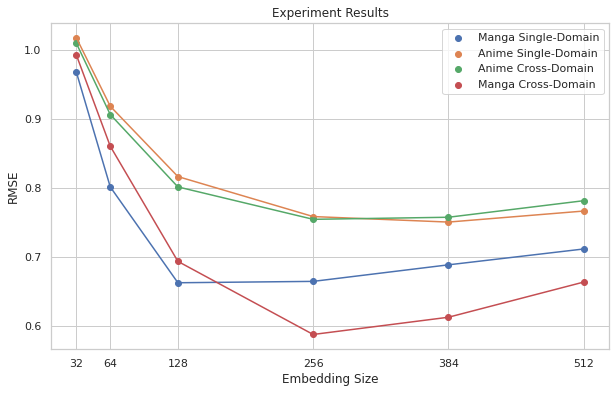

In [ ]:
# Plot
emb_size = [32, 64, 128, 256, 384, 512]
results = [
           [ .968, .802, .663, .665, .689, .712],  # manga single domain
           [1.018, .919, .817, .759, .751, .767],  # anime single domain
           [1.01,  .907, .802, .755, .758, .782],  # full manga cdrs
           [ .993, .861, .694, .588, .613, .664],  # full anime cdrs
]

results = np.array(results)
labels = ['Manga Single-Domain', 'Anime Single-Domain',
          'Anime Cross-Domain', 'Manga Cross-Domain']

for res, label in zip(results, labels):
  plt.scatter(x = emb_size, y = res, label=label)
  plt.plot(emb_size, res)

plt.xticks(emb_size)
plt.ylabel('RMSE')
plt.xlabel('Embedding Size')
plt.legend()
plt.title('Experiment Results')

#### Rekomendasi

##### Membuat Indexes

In [ ]:
'''Save best model'''
CONFIG = [
    [128, 'Manga Single'], [256, 'Anime Single'], [256, 'Manga Cross'], [256, 'Anime Cross'],
]

for config in CONFIG:
    print(f'Processing: {config}')
    save_model(config)

In [ ]:
!gdown --quiet --id 1S-wmljWziiaNI5AsMaP5cbC9BVm-Jhx5  # Manga CDRS model

In [ ]:
PATH = 'FA_test__256.pth'
model = torch.load(PATH)
model._net.eval()
model._use_cuda

In [ ]:
'''Batch dump computed matrix operation'''
DUMP_PATH = '/content/drive/MyDrive/dataset/cdrs-indexes'

num_users, num_items = df.shape
batch = 1000
batch_num = (num_users // batch) + 1

for i in range(batch_num):
    start = batch*i
    stop = batch*(i+1)

    if i == batch_num-1:
        # if last batch, get remaining users left
        remaining_users = num_users % batch
        computed_matrix = np.zeros((remaining_users, num_items))
        
        stop = start + remaining_users
    else:
        computed_matrix = np.zeros((batch, num_items))

    for u in range(start, stop):
        pred = model.predict(u)
        index = u-start
        computed_matrix[index] = pred

    FILE_NAME = f'{start}-{stop}.pkl'
    print(f'Dumping {FILE_NAME}')
    computed_matrix.dump(f'{DUMP_PATH}/{FILE_NAME}')

##### Rekomendasi via Ranking

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
CLEAN_DATA_PATH = '/content/drive/MyDrive/dataset/anime/train-test-split/clean_data.csv'
COMPUTED_MATRIX_PATH = '/content/drive/MyDrive/dataset/anime/14900-15744.pkl'

In [ ]:
df = pd.read_csv(CLEAN_DATA_PATH)

In [ ]:
'''Create easily indexable item lists'''
items_index = df[['type', 'item', 'title']].drop_duplicates()
items_index = items_index.set_index('item').sort_index()

In [ ]:
'''Example, load the last 844 users'''
computed_matrix = np.load(COMPUTED_MATRIX_PATH, allow_pickle=True)
computed_matrix.shape

(844, 22685)

In [ ]:
'''Example from the last entry'''
df.tail(1)

,username,user,type,item,title,rating
4397292,vvioo,15743,manga,20357,Shingeki no Kyojin,9


In [ ]:
'''Get computed ratings of the last users by indexing directly to the matrix'''
# get the ratings
ratings = computed_matrix[-1]

# optional: bound values between 1 and 10
ratings = ratings.clip(1,10)

# get the ratings for certain items
ratings[20357]

9.109247207641602

In [ ]:
# utility ranking function
topk_rank = partial(_topk_rank, crm=computed_matrix, items_index=items_index, df=df)

In [ ]:
'''Recommendation for vvioo'''
# 15743 - 14900 = 843
recs = topk_rank(843, 100, 'manga')
recs

,type,title
item,,
15745,manga,JoJo no Kimyou na Bouken Part 5: Ougon no Kaze
11394,manga,20th Century Boys
15113,manga,Holyland
14348,manga,Golden Kamuy
15248,manga,Houseki no Kuni
16400,manga,Kimi no Na wa.
22164,manga,Wind Breaker
11414,manga,3-gatsu no Lion
11800,manga,All You Need Is Kill
